<a href="https://colab.research.google.com/github/ahmadmwali/Projects/blob/main/Bayesian%20Neural%20Nets/Multiclass_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass Neural Network

Ahmad Mustapha Wali
Group 407

In [ ]:
#Importing the relevant libraries and modules
import theano
import arviz as az
import numpy as np
import pymc3 as pm
import seaborn as sns
sns.set_style("white")
import tensorflow as tf
filterwarnings("ignore")
sns.set_palette("muted")
import theano.tensor as T
from scipy.stats import mode
from tensorflow import keras
floatX = theano.config.floatX
import matplotlib.pyplot as plt
from warnings import filterwarnings
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
%config InlineBackend.figure_format = 'retina'
from pymc3.variational.callbacks import CheckParametersConvergence

In [ ]:
'''Importing the MNIST dataset from Keras. The dataset is flattened and 
normalized, then set to a dtype of float64'''

(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
X_train = (X_train.reshape(-1, 28**2) / 255.).astype(floatX)
X_test = (X_test.reshape(-1, 28**2) / 255.).astype(floatX)
Y_train = Y_train.astype(floatX)
Y_test = Y_test.astype(floatX)

11501568/11490434 [==============================] - 0s 0us/step


Text(0.5, 0.98, 'Training data and corresponding labels')

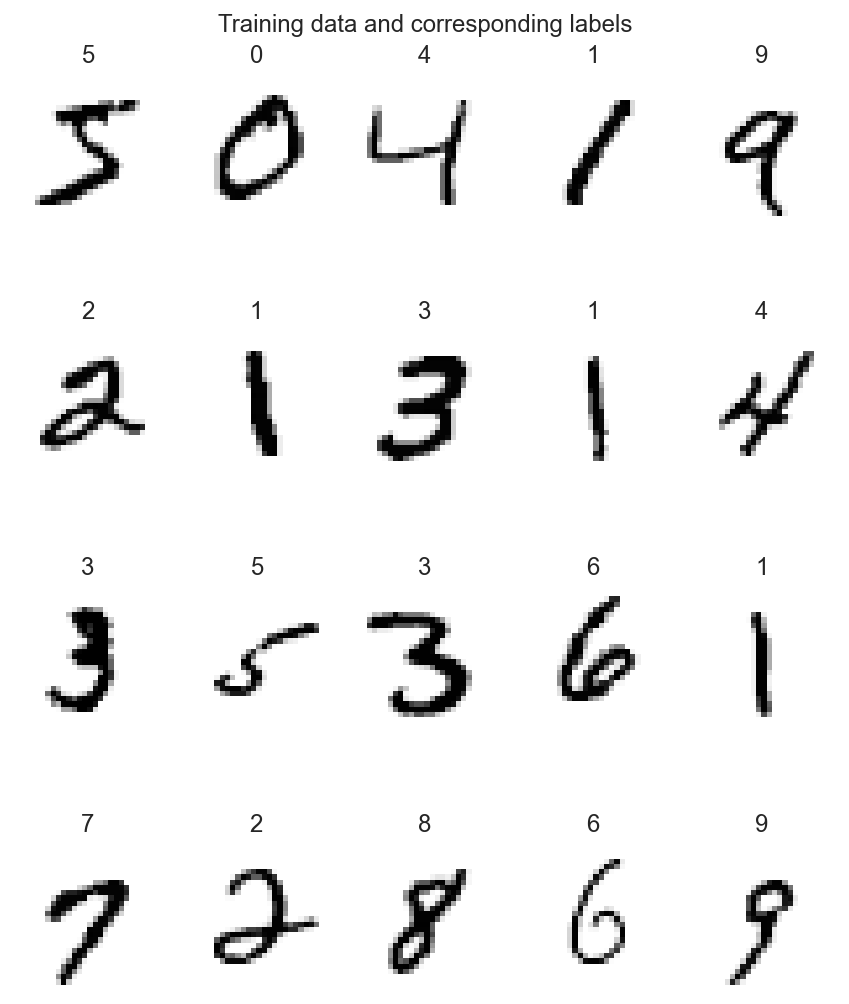

In [ ]:
#Prinitng the initial elements of the train dataset with their corresponding labels

fig, ax = plt.subplots(4,5, figsize=(6,7.5))
for i in range(20):
    ax[i//5, i % 5].imshow(X_train[i].reshape(28, 28), cmap="Greys")
    ax[i//5, i % 5].axis("off")
    ax[i//5, i % 5].set_title(int(Y_train[i]))
    
fig.tight_layout()
fig.suptitle("Training data and corresponding labels")

Finished [100%]: Average Loss = 32.583


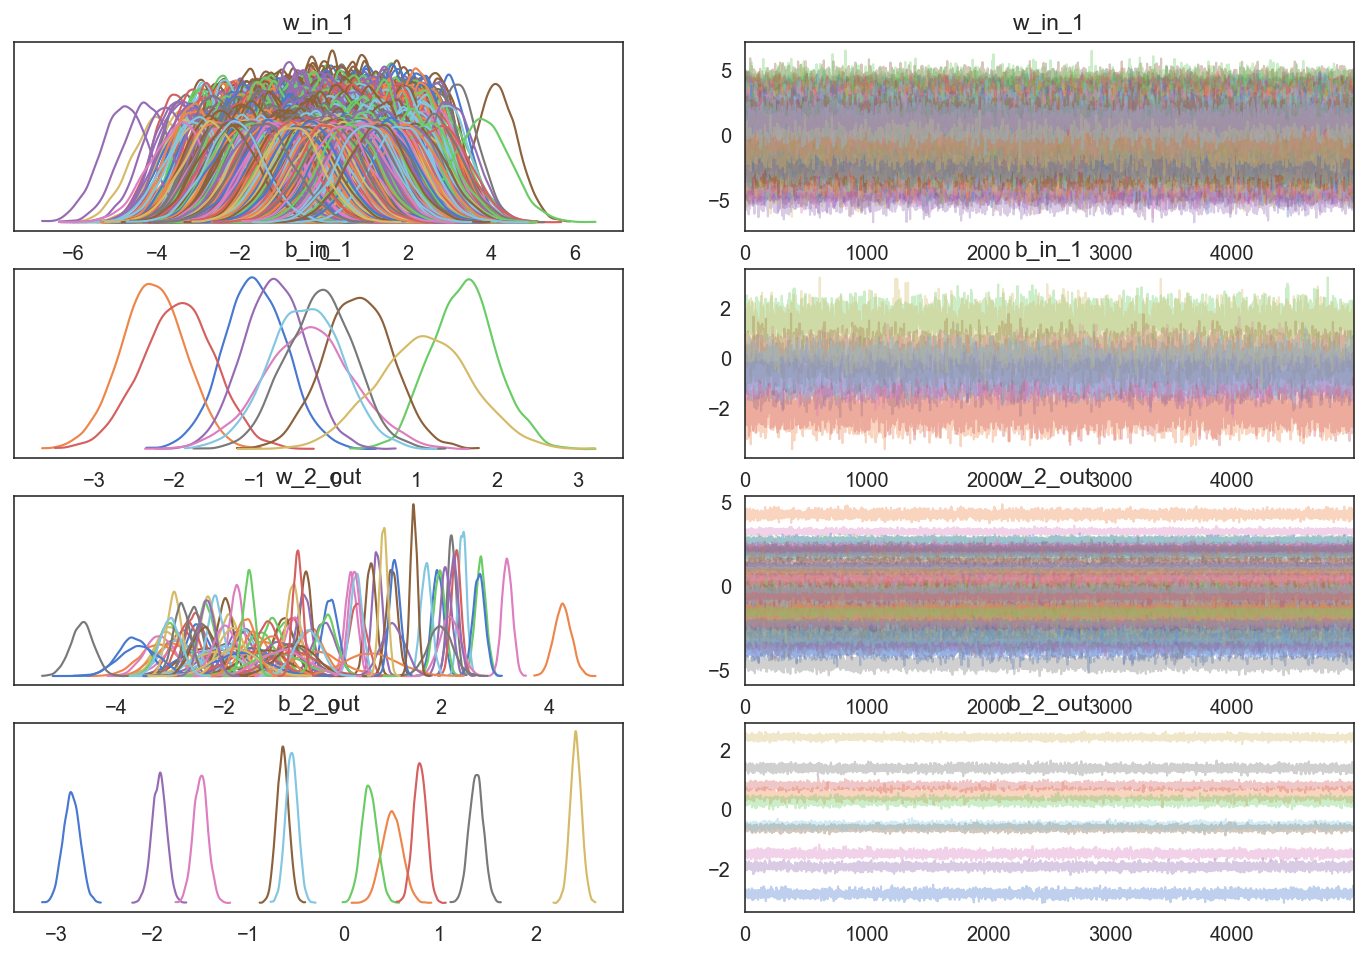

In [ ]:
'''For faster training, the neural network was designed to have
only 1 hidden layer, unlike the binary with 3. Biases are however added
to the hidden and output layer. The network also has 10 neurons per layer.'''

#Specifying the hidden neuron numbers
n_hidden = 10

#Initializing random weights between each layer and the biases
init_1 = np.random.randn(X_train.shape[1], n_hidden).astype(floatX)
init_1_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
init_bias_1 = np.random.randn(n_hidden).astype(floatX)
init_out = np.random.randn(n_hidden, 10).astype(floatX)
init_bias_out = np.random.randn(10).astype(floatX)

#Defining the model
with pm.Model() as multiclass_neural_network:
    
    #Setting the inputs and outputs as shared variables
    input = pm.Data("input", X_train)
    output = pm.Data("output", Y_train)
    
    #Setting the priors of the weights as normal distributions
    weights_in_1 = pm.Normal("w_in_1", 0, sigma=1, shape=(X_train.shape[1], n_hidden), testval=init_1)
    bias_in_1 = pm.Normal("b_in_1", 0, sigma=1, shape=(n_hidden), testval=init_bias_1)
    weights_2_out = pm.Normal("w_2_out", 0, sigma=1, shape=(n_hidden, 10), testval=init_out)
    bias_2_out = pm.Normal("b_2_out", 0, sigma=1, shape=(10), testval=init_bias_out)

    #Activation functions    
    act_1 = pm.math.sigmoid(pm.math.dot(input, weights_in_1) + bias_in_1)
    act_out = T.nnet.softmax(pm.math.dot(act_1, weights_2_out) + bias_2_out)
    
    #The likelihood function set as a Categorical variable
    out = pm.Categorical("out", p=act_out, observed=output.T, total_size=X_train.shape[0])
    
    #Fitting and training the dataset with minibatch using an ADVI sampler 
    inference = pm.ADVI()
    X_batch = pm.Minibatch(X_train, batch_size=50)
    Y_batch = pm.Minibatch(Y_train, batch_size=50)
    approx = pm.fit(n=50000, method=inference, callbacks=[CheckParametersConvergence()],
                    more_replacements={input: X_batch, output: Y_batch})
    trace_advi = approx.sample(5000)
    
    '''Testing the network using the testset, and plotting the posterior weight distributions. 
    Unlike in the binary network, weight distributions are so many, and will take up much space 
    if plotted individually, so I used the az.plot_trace() method to superimpose the distributions 
    on one another.'''
    az.plot_trace(trace_advi)
    pm.set_data(new_data={"input": X_test, "output": Y_test}, model=multiclass_neural_network)
    ppc = pm.sample_posterior_predictive(trace_advi, samples=1000, progressbar=True, model=multiclass_neural_network)

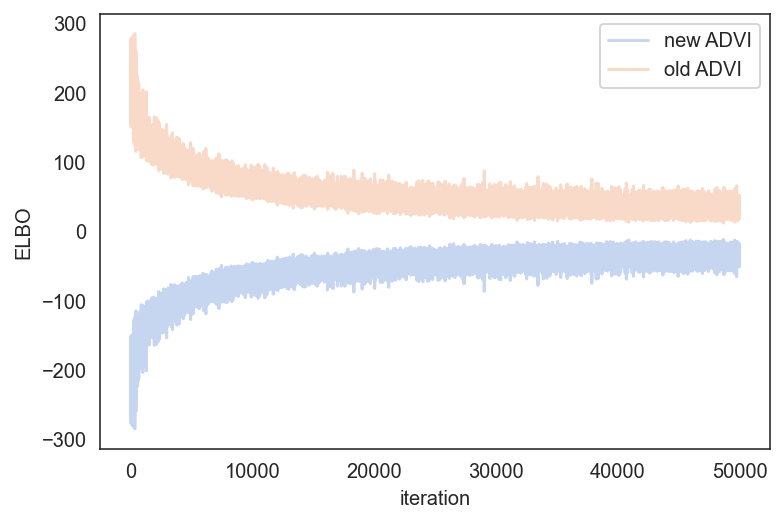

In [ ]:
#Optimization plot for evidence-based lower bound, which is the equivalent 
# of the Kullback-Leibler (KL) divergence, for the inferences.
plt.plot(-inference.hist, label="new ADVI", alpha=0.3)
plt.plot(approx.hist, label="old ADVI", alpha=0.3)
plt.legend()
plt.ylabel("ELBO")
plt.xlabel("iteration");

It could be observed that the optimization improved rapidly up to the 10000th iteration then continued gradually over time.

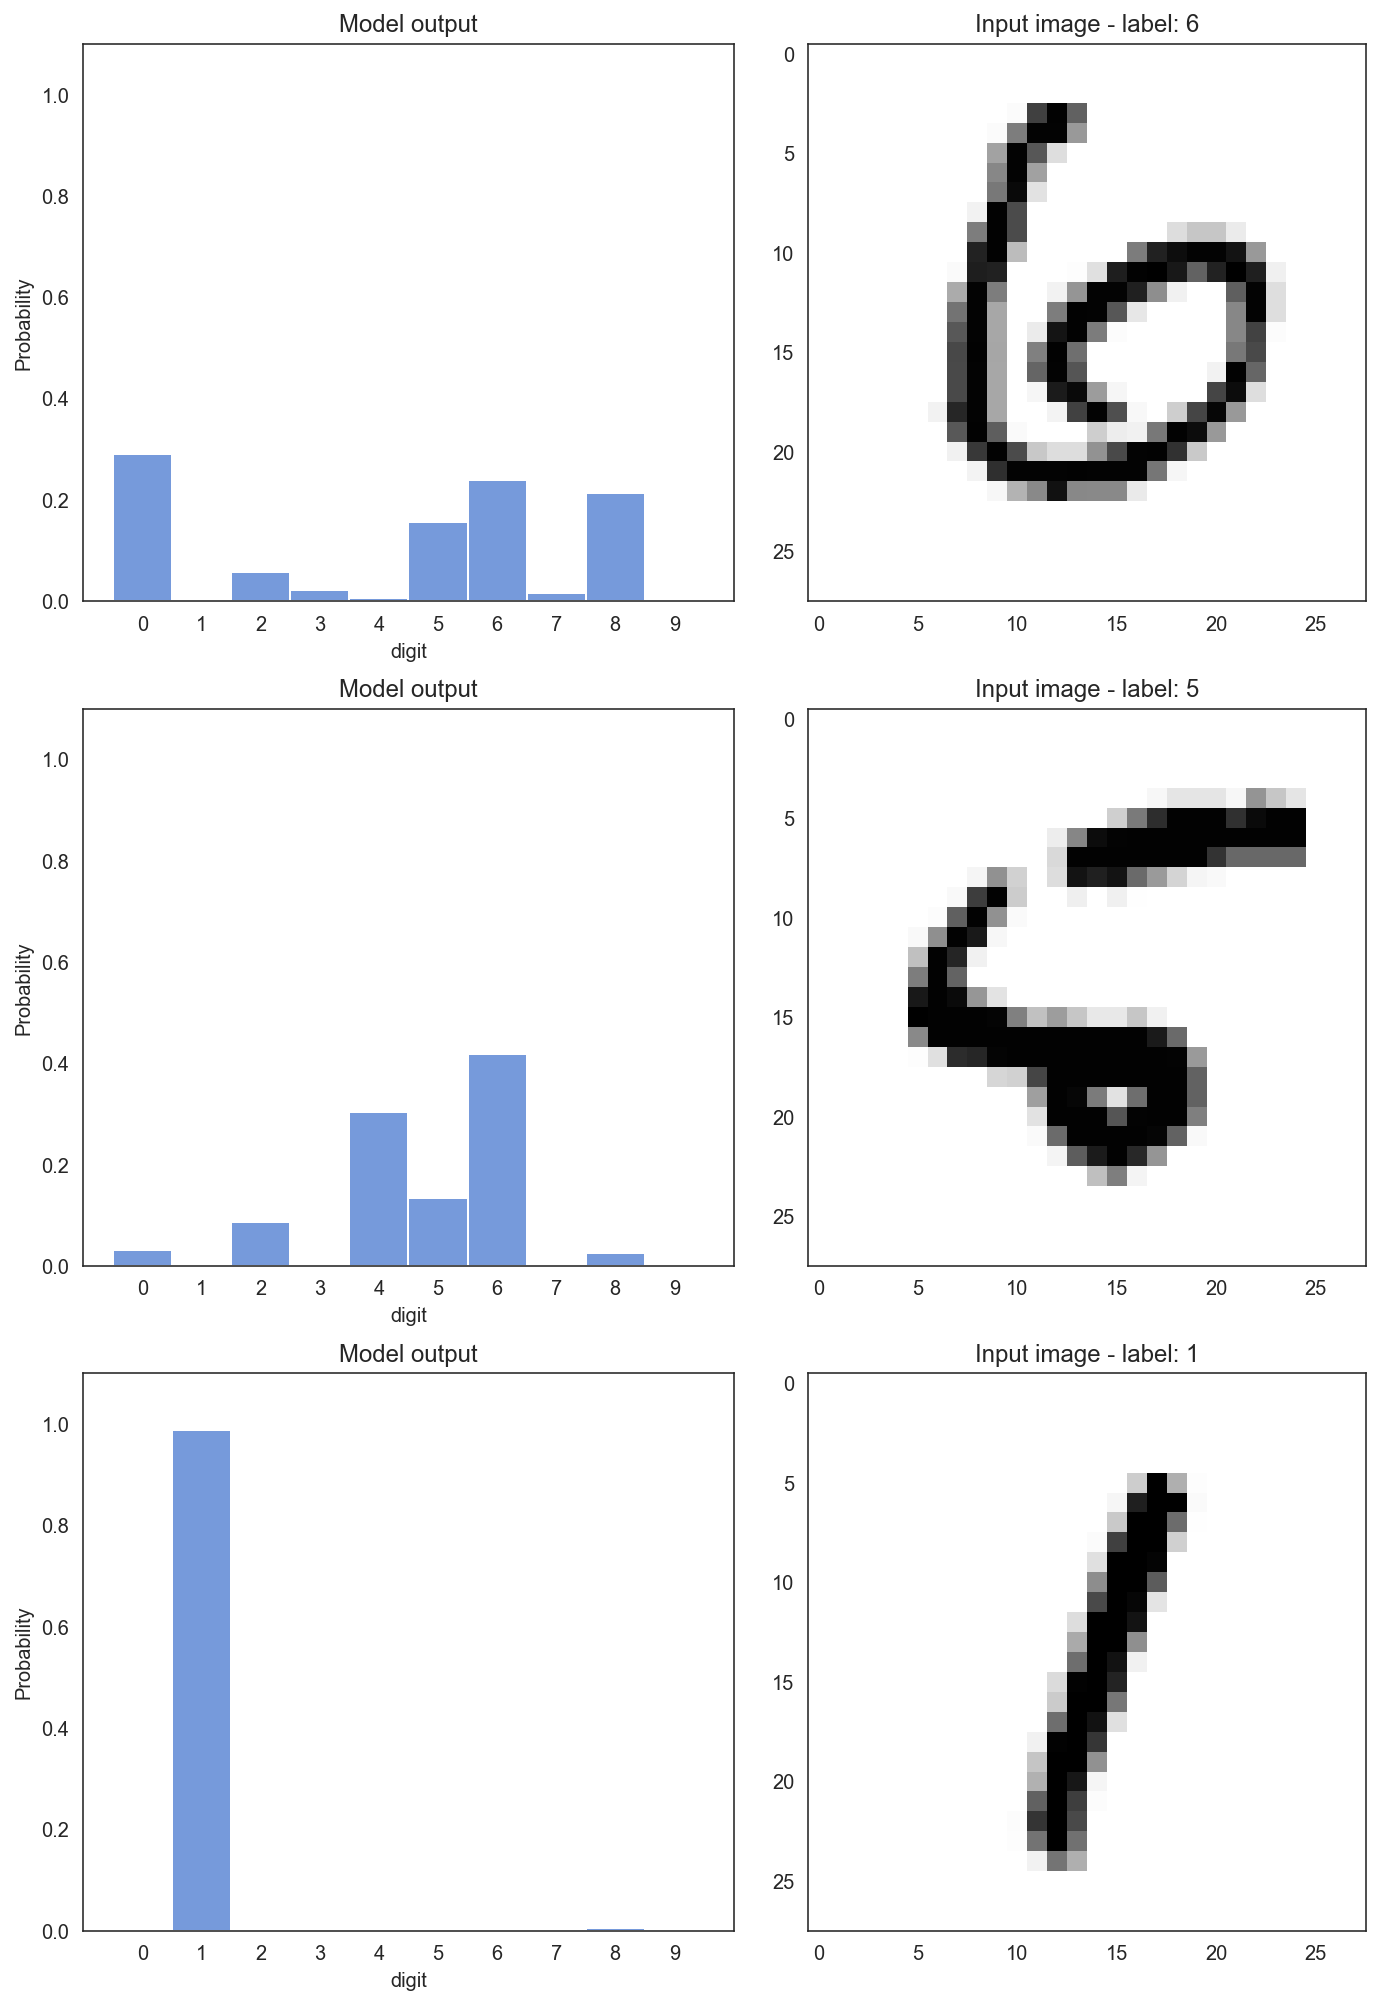

In [ ]:
'''A plot of what the model has learnt using some samples with a histogram probability distribution of the test data. 
The ode of the histogram is selected to as the predicted number.'''

idx = 11
fig, ax = plt.subplots(3,2, figsize=(10, 14))

for n, idx in enumerate([11,8,5]):
    sns.histplot(ppc["out"][:, idx], stat="probability", color="C0", bins=np.arange(10)-0.5, ax=ax[n, 0])
    ax[n, 0].set_ylim(0,1.1)
    ax[n, 0].set_xlim(-1, 10)
    ax[n, 0].set_xticks(np.arange(10))
    ax[n, 0].set_xlabel("digit")
    ax[n, 0].set_title("Model output")
    ax[n, 1].imshow(X_test[idx].reshape(28,28), cmap="Greys")
    ax[n, 1].set_title(f"Input image - label: {int(Y_test[idx])}")
    
fig.tight_layout()

In [ ]:
#Creating a variable of the predictions from the model
y_pred = mode(ppc["out"]).mode[0,:]
print(f"Test set accuracy: {100*accuracy_score(Y_test, y_pred)}%")

Test set accuracy: 87.97%


# Sanity Check

In this section, 2 sets of random numbers were created, then fed into the previously-created multiclass neural network. The network, however, has a fixed distribution of weights instead of a distribution of random numbers.

In [ ]:
#Creating a function for generating a set of 100 random numbers
def generate():
  X_Sanity = X = np.random.randn(100, 2)
  Y_Sanity = Y = np.tanh(X[:, 0] + X[:, 1])
  Y_Sanity = 1. / (1. + np.exp(-(Y + Y)))
  Y_Sanity = Y > 0.5

  return X_Sanity, Y_Sanity

In [ ]:
#Generating the test and training data
Sanity_X_train, Sanity_Y_train = generate()
Sanity_X_test, Sanity_Y_test = generate()

In [ ]:
#Scaling the train set along the X axis, and setting it to a float64 dtype.
Sanity_X_train = scale(Sanity_X_train)
Sanity_X_train = Sanity_X_train.astype(floatX)
Sanity_Y_train = Sanity_Y_train.astype(floatX)

In [ ]:
#Scaling the train set along the X axis, and setting it to a float64 dtype.
Sanity_X_test = scale(Sanity_X_test)
Sanity_X_test = Sanity_X_test.astype(floatX)
Sanity_Y_test = Sanity_Y_test.astype(floatX)

Finished [100%]: Average Loss = 32.433


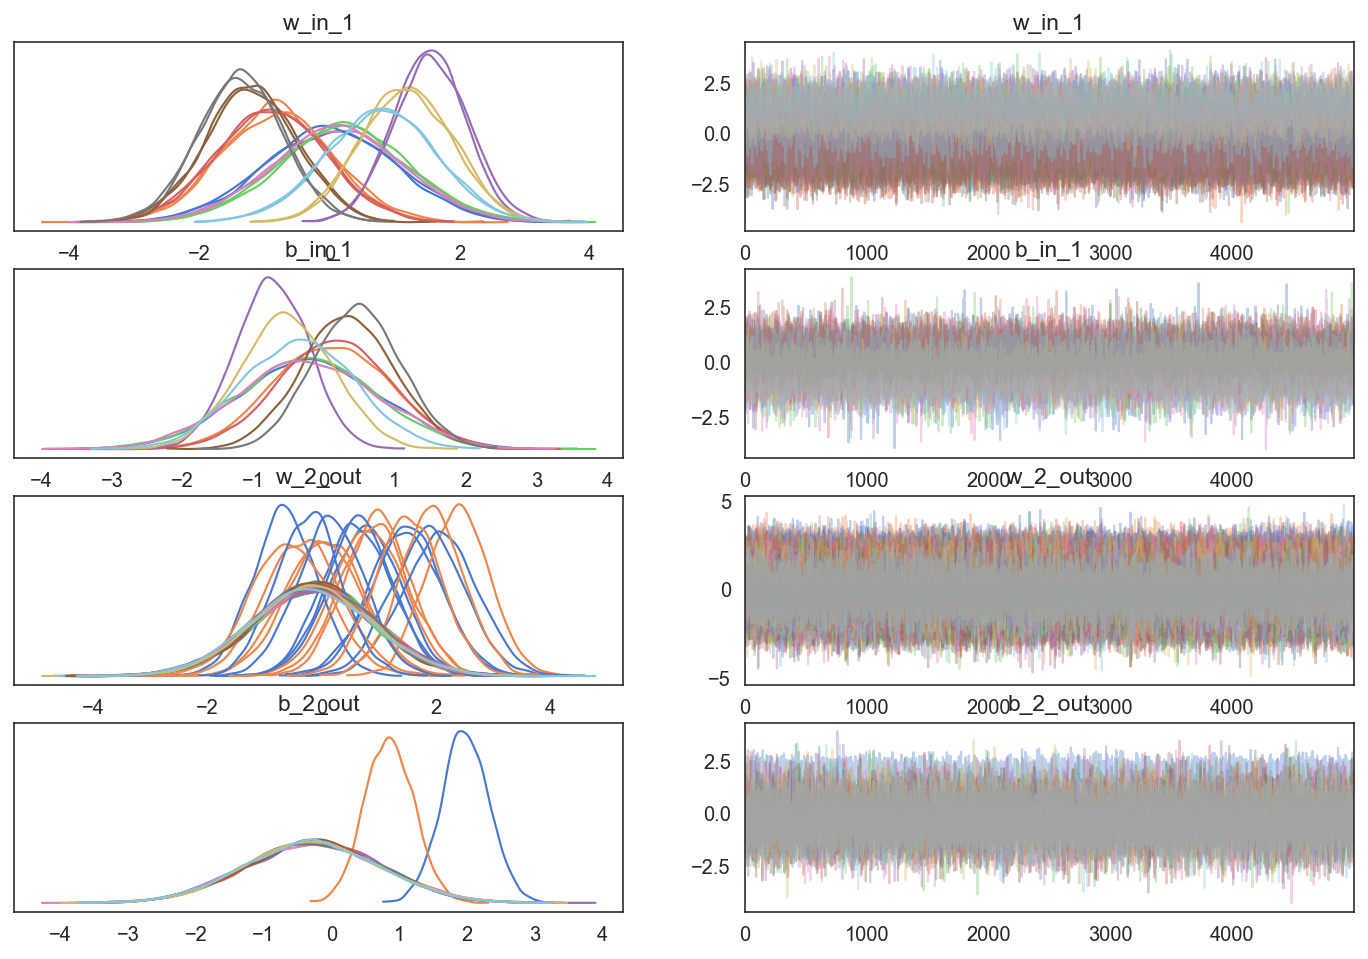

In [ ]:
#Specifying the hidden neuron numbers
n_hidden = 10

#Initializing random weights between each layer and the biases
init_1 = np.ones((Sanity_X_train.shape[1], n_hidden)).astype(floatX)
init_1_2 = np.ones((n_hidden, n_hidden)).astype(floatX)
init_bias_1 = np.ones((n_hidden)).astype(floatX)
init_out = np.ones((n_hidden, 10)).astype(floatX)
init_bias_out = np.ones((10)).astype(floatX)

#Defining the model
with pm.Model() as Sanity_neural_network:
    
    #Setting the inputs and outputs as shared variables
    ann_input = pm.Data("ann_input", Sanity_X_train)
    ann_output = pm.Data("ann_output", Sanity_Y_train)
    
    #Setting the priors of the weights as normal distributions
    weights_in_1 = pm.Normal("w_in_1", 0, sigma=1, shape=(Sanity_X_train.shape[1], n_hidden), testval=init_1)
    bias_in_1 = pm.Normal("b_in_1", 0, sigma=1, shape=(n_hidden), testval=init_bias_1)
    weights_2_out = pm.Normal("w_2_out", 0, sigma=1, shape=(n_hidden, 10), testval=init_out)
    bias_2_out = pm.Normal("b_2_out", 0, sigma=1, shape=(10), testval=init_bias_out)

    #Activation functions    
    act_1 = pm.math.sigmoid(pm.math.dot(ann_input, weights_in_1) + bias_in_1)
    act_out = T.nnet.softmax(pm.math.dot(act_1, weights_2_out) + bias_2_out)
    
    #The likelihood function set as a Categorical variable
    out = pm.Categorical("out", p=act_out, observed=ann_output.T, total_size=Sanity_X_train.shape[0])
    
    #Fitting and training the dataset with minibatch using an ADVI sampler 
    inference = pm.ADVI()
    X_batch = pm.Minibatch(Sanity_X_train, batch_size=50)
    Y_batch = pm.Minibatch(Sanity_Y_train, batch_size=50)
    approx = pm.fit(n=50000, method=inference, callbacks=[CheckParametersConvergence()], 
                    more_replacements={ann_input: X_batch, ann_output: Y_batch})
    
    #Traceplots of the samples
    trace_advi = approx.sample(5000)
    az.plot_trace(trace_advi)
    pm.set_data(new_data={"ann_input": Sanity_X_test, "ann_output": Sanity_Y_test}, model=Sanity_neural_network)
    ppc = pm.sample_posterior_predictive(trace_advi, samples=1000, progressbar=True, model=Sanity_neural_network)

Text(0.5, 0, 'iteration')

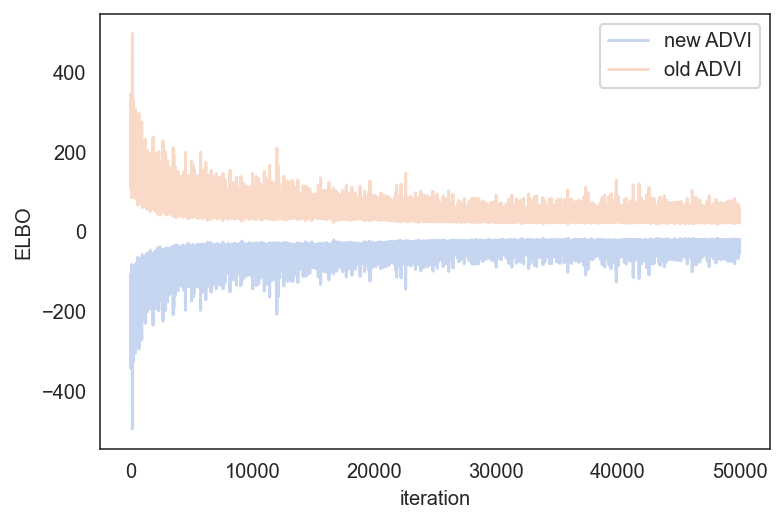

In [ ]:
#ELBO plot of the inference. It could also be noticed that it improves over time
#though not as good as the one with random weights
plt.plot(-inference.hist, label="new ADVI", alpha=0.3)
plt.plot(approx.hist, label="old ADVI", alpha=0.3)
plt.legend()
plt.ylabel("ELBO")
plt.xlabel("iteration")

In [ ]:
#Predicting the test set and its accuracy
Sanity_y_pred = mode(ppc["out"]).mode[0,:]
print(f"Test set accuracy: {100*accuracy_score(Sanity_Y_test, Sanity_y_pred)}%")

Test set accuracy: 85.0%


# Classical Neural Network

In this section, I implemented the same network architecture using Keras from TensorFlow. I used Adam optimizer for gradient descent. The model also calculates cross entropy obtained as a result of testing.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='tanh'),
    tf.keras.layers.Dense(10, activation='tanh'),
    tf.keras.layers.Dense(10, activation='tanh'),
    tf.keras.layers.Dense(10, activation='sigmoid')])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, Y_train, epochs=20)

Epoch 1/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.6165 - accuracy: 0.8474
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3079 - accuracy: 0.9135
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2735 - accuracy: 0.9218
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2519 - accuracy: 0.9275
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2361 - accuracy: 0.9329
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2262 - accuracy: 0.9355
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2177 - accuracy: 0.9377
Epoch 8/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2098 - accuracy: 0.9397
Epoch 9/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2049 - accuracy: 0.9408
Epoch 10/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.200

In [ ]:
#Testing the values against the predictions.
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)
print(f"Test set accuracy: {100*test_acc}%")

313/313 - 1s - loss: 0.2213 - accuracy: 0.9398 - 523ms/epoch - 2ms/step
Test set accuracy: 93.98000240325928%


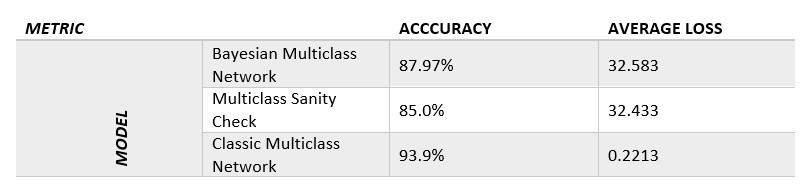


The classic model performed much better than the bayesian models. It also has significantly less losses than the others as well. Comparing the results with those of the binary classifier, it could be observed that the multiclass network performed better on average. A possible explanation could be that, despite having fewer layer, the multiclass networks have a higher number of hidden neurons.

Another observation (which is not part of this notebook) is that, for some unknown reason, multiclass networks perform very poor when only using a categorical variable without a bias term. Earlier results I got were around 1% to less than 10%.